# Chapter 6: Planning
지능적인 행동은 단순히 즉각적인 입력에 반응하는 것 이상을 포함한다
- 예측
- 복잡한 태스크를 더 작고 관리가능한 단계로 나누는 능력
- 그리고 원하는 결과를 달성하기 위한 전략적 사고

플래닝 패턴은 초기 상태에서 목표한 상태로 향하기 위해 액션의 순소를 구성하는 에이전트의 능력이다.

## Planning Pattern Overview 

플래닝 에이전트를 복잡한 목표를 위임할 수 있는 전문가로 생각해야한다. 

"팀 오프사이트를 조직해줘" 라고 요청하면, 무엇(what) -- 목적과 제약사항 -- 을 정의하는 것이지, 어떻게(how)를 정의하지는 않는다. 

에이전트의 코어 태스크는 목표로 향하는 코스를 자율적으로 설계하는 것이다.

1. 초기 상태(예산, 참가자 수, 원하는 날짜)를 이해
2. 목표 상태(성공적으로 예약된 오프사이트)를 정함
3. 두 상태를 연결하기 위한 최적의 액션 시퀀스를 찾아낸다.

계획은 미리 알고 있는 것이 아니다; 요청에 대한 응답에서 생성되는 것이다.

Agent의 플래닝 패턴의 특징은 적응력(Adaptability), 예를 들어

`미리 선호한 장소가 사용 불가 해졌다면, 에이전트는 단순히 실패하지 않는다`

새로운 정보를 받아 들이고, 장애물을 제약 조건으로 새롭게 인식한 다음, 가능한 선택지를 다시 평가하고 새로운 계획을 세운다.


유도리와 예측 가능성의 트레이드-오프를 인식하는 것이 중요하다. 
Dynamic planning이 항상 만능인 솔루션이 아니다. 

문제의 해결 방법이 잘 이해되어 있고, 반복 가능한 경우, 에이전트를 미리 정해진 고정된 워크플로우로 제한하는 편이 더 효과적이다. 
에이전트의 자율성을 제한 하는 대신 예측하지 못한 행동에 대한 리스크를 줄이고, 신뢰할 수 있고 일관된 결과를 보장한다.

플래닝 에이전트 VS 단순 태스크 실행 에이전트 : 어떻게(how)를 새롭게 발굴해야하는가 VS 이미 알고있는가?

# Practical Applications & Use Cases
복잡한 일들을 순서 있게 잘 처리할 수 있도록 도와주는 지능적인 설계 방식
### 절차적 업무 자동화(procedural task automation)
플래닝 패턴이 복잡한 워크플로우 오케스트레션에 사용된다. 새로운 직원 온보딩의 경우, 
- 시스템 계정 생성
- 트레이닝 모듈 할당
- 여러 다른 부서 들과 협업 조율
에이전트가 이러한 스텝 들을 논리적 순서로 수행하기 위한 계획을 생성하고, 필요한 툴 호출을 하거나 시스템과 상호작용해서 스텝 간의 의존성을 관리한다.

### 로보틱스와 자율 주행
플래닝 패턴이 상태 공간(state-space)을 탐색하는 근본이다. 목표 상태로 이동하기 위해 경로 또는 액션의 시퀀스를 생성해야 한다.
시간 혹은 에너지 소비와 같은 메트릭을 최적화하는 것을 포함하고, 장애물 회피나 교통 규칙 준수 같은 환경적 제약을 고려해야한다

### 구조화된 정보 종합(structured information synthesis)
리서치 보고서 같은 복잡한 결과물을 생성해야하는 태스크 수행 시, 
- 정보 수집
- 데이터 요약
- 컨텐츠 구조화
- 반복적 개선
같은 명확히 구분된 단계를 포함하는 계획을 세운다.

여러 단계를 거치는 태스크 수행 시, 에이전트가
- 진단
- 솔루션 구현
- 상위 단계로 에스컬레이션
같은 체계적인 계획을 생성하고 따라야한다.





In [5]:
from __future__ import annotations

from typing import List, Dict,TypedDict
from typing_extensions import Annotated
from dataclasses import dataclass
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AnyMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import interrupt


CrewAI의 Agent/Task 메타를 상태로 모델링

In [6]:
@dataclass
class AgentSpec:
    name: str
    role: str
    goal: str
    backstory: str

@dataclass
class TaskSpec:
    name: str
    description: str
    expected_output: str


class Plan(BaseModel):
    steps: List[str] = Field(description="정확한 요약을 위한 순차적 단계들 ( 4-6 단계 )")

class Critique(BaseModel):
    is_perfect: bool = Field(description="초안이 완벽한지 여부 ( `True` 또는 `False` )")
    issues: List[str] = Field(default_factory=list, description="문제들, 스타일, 엣지 케이스 등")
    guidance: str = Field(default="", description="개선하기 위한 구체적인 지침")

# 그래프 상태를 나타내는 TypedDict ( State-first 접근 방식 )
class GraphState(TypedDict):
    topic: str
    agents: Dict[str, AgentSpec]
    tasks: Dict[str, TaskSpec]

    need_plan_approval: bool
    max_revisions: int
    revision_count: int

    plan: List[str]
    draft: str
    critique: Critique | None
    report: str

    messages: Annotated[List[AnyMessage], add_messages()]

LLM

In [7]:
planner_llm = ChatOpenAI(
    model="qwen3-4b-q4_k_m",
    base_url="http://127.0.0.1:8080/v1",
    api_key="llama.cpp",
    temperature=0
)
writer_llm = ChatOpenAI(
    model="qwen3-4b-q4_k_m",
    base_url="http://127.0.0.1:8080/v1",
    api_key="llama.cpp",
    temperature=0.2
)
review_llm = ChatOpenAI(
    model="qwen3-4b-q4_k_m",
    base_url="http://127.0.0.1:8080/v1",
    api_key="llama.cpp",
    temperature=0
)

Agent별 프롬프트 (역할/목표/백스토리를 system에 )

In [8]:
def make_planner_prompt(agent: AgentSpec) -> ChatPromptTemplate:
    return ChatPromptTemplate.from_messages([
        ("system",
         f"당신은 {agent.name}. 역할: {agent.role}\n"
         f"목표: {agent.goal}\n"
         f"배경 이야기: {agent.backstory}\n"
         "먼저 계획을 세우세요. 출력은 간결하고 실행 가능한 단계(4-6개)여야 합니다."),
        ("human", "주제: {topic}")
    ])

def make_writer_prompt(agent: AgentSpec) -> ChatPromptTemplate:
    return ChatPromptTemplate.from_messages([
        ("system",
         f"당신은 {agent.name}. 역할: {agent.role}\n"
         f"목표: {agent.goal}\n"
         f"배경 이야기: {agent.backstory}\n"
         "명확하게 작성하고 주어진 계획을 따르세요. 약 200단어를 목표로 하세요."),
        ("human", "주제: {topic}\n계획:\n{plan_bullets}\n\n최종 요약을 작성하세요.")
    ])

def make_revise_prompt(agent: AgentSpec) -> ChatPromptTemplate:
    return ChatPromptTemplate.from_messages([
        ("system",
         f"당신은 {agent.name}. 역할: {agent.role}\n"
         f"목표: {agent.goal}\n"
         f"배경 이야기: {agent.backstory}\n"
         "비판과 계획을 엄격히 따르며 요약을 수정하세요."),
        ("human", "주제: {topic}\n계획:\n{plan_bullets}\n\n현재 초안:\n{draft}\n\n비판:\n{critique}\n\n초안을 수정하세요.")
    ])

review_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "당신은 파이써닉하고, 쓸데없는 말을 하지 않는 리뷰어입니다. "
     "초안이 모든 요구 사항을 충족하는지 확인하세요: 계획을 따르고; 명확하고 간결하며; ~200단어입니다. "
     "완벽하다면 is_perfect를 true로 설정하세요. 그렇지 않다면 구체적인 문제를 나열하고 지침을 제공하세요."),
    ("human", "주제: {topic}\n계획:\n{plan_bullets}\n\n초안:\n{draft}")
])

노드들 (순수 함수: 상태→부분 업데이트 반환)

In [9]:
def plan_node(state: GraphState) -> GraphState:
    agent = state["agents"]["planner"]
    chain = make_planner_prompt(agent) | planner_llm.with_structured_output(Plan)
    plan_obj: Plan = chain.invoke({"topic": state["topic"]})
    steps = plan_obj.steps

    if state.get("need_plan_approval", False):
        approved_or_feedback = interrupt(
            "계획을 승인 하시겠습니까? 진행하려면 `yes`를 입력하거나 변경을 요청하려면 피드백을 작성하세요."
        )
        if isinstance(approved_or_feedback, str) and approved_or_feedback.lower() != "yes":
            feedback = approved_or_feedback
            replan_chain = ChatPromptTemplate.from_messages([
                ("system", "당신은 계획 재작성 전문가입니다. 사용자의 피드백을 바탕으로 계획을 개선하세요."),
                ("human", "원래 주제: {topic}\n현재 계획:\n{cur}\n\n피드백:\n{fb}\n\n개선된 계획을 작성하세요.")
            ]) | planner_llm.with_structured_output(Plan)
            plan_obj = replan_chain.invoke({"topic": state["topic"], "cur": "\n".join(steps), "fb": feedback})
            steps = plan_obj.steps

    return {
        "plan": steps,
        "messages": [AIMessage(content=f"(planner) 계획 단계 생성됨")]
    }

In [10]:
def write_node(state: GraphState) -> GraphState:
    agent = state["agents"]["writer"]
    bullets = "\n".join(f"- {step}" for step in state["plan"])
    chain = make_writer_prompt(agent) | writer_llm
    ai = chain.invoke({"topic": state["topic"], "plan_bullets": bullets})
    return {
        "draft": ai.content if hasattr(ai, "content") else str(ai),
        "messages": [AIMessage(content=f"(writer) 초안 작성됨")]
    }


In [11]:
def review_node(state: GraphState) -> GraphState:
    bullets = "\n".join(f"- {step}" for step in state["plan"])
    chain = review_prompt | review_llm.with_structured_output(Critique)
    critique: Critique = chain.invoke({
        "topic": state["topic"],
        "plan_bullets": bullets,
        "draft": state["draft"]
    })
    return {
        "critique": critique,
        "messages": [AIMessage(content=f"(reviewer) 초안 검토됨")]
    }

In [12]:
def revise_node(state: GraphState) -> GraphState:
    agent = state["agents"]["writer"]
    bullets = "\n".join(f"- {step}" for step in state["plan"])
    critique_str = (
        f"is_perfect: {state['critique'].is_perfect}\n"
        f"issues: " + ", ".join(state['critique'].issues) + "\n"
        f"guidance: {state['critique'].guidance}"
    )
    chain = make_revise_prompt(agent) | writer_llm
    ai = chain.invoke({
        "topic": state["topic"],
        "plan_bullets": bullets,
        "draft": state["draft"],
        "critique": critique_str
    })
    return {
        "draft": ai.content if hasattr(ai, "content") else str(ai),
        "revision_count": state.get("revision_count", 0) + 1,
        "messages": [AIMessage(content=f"(writer) 초안 수정됨")]
    }

In [13]:
def format_report_node(state: GraphState) -> GraphState:
    plan_sec = "\n".join(f"- {step}" for step in state["plan"])
    report = (
        "### 계획\n"
        f"{plan_sec}\n\n"
        "### 요약\n"
        f"{state['draft']}"
    )
    return {"report": report}

분기 로직

In [ ]:
def route_after_review(state: GraphState) -> str:
    critique: Critique = state["critique"]
    if critique.is_perfect:
        return "format"

    if state.get("revision_count", 0) < state.get("max_revisions", 3):
        return "format" # 한도 초과 시, 초안으로 보고서 작성
    return "revise"


그래프 구성 

In [15]:
builder = StateGraph(GraphState)

builder.add_node("plan", plan_node)
builder.add_node("write", write_node)
builder.add_node("review", review_node)
builder.add_node("revise", revise_node)
builder.add_node("format", format_report_node)

builder.add_edge(START, "plan")
builder.add_edge("plan", "write")
builder.add_edge("write", "review")
builder.add_conditional_edges("review", route_after_review, {
    "format": "format",
    "revise": "revise"
})
builder.add_edge("revise", "review")
builder.add_edge("format", END)

app = builder.compile()

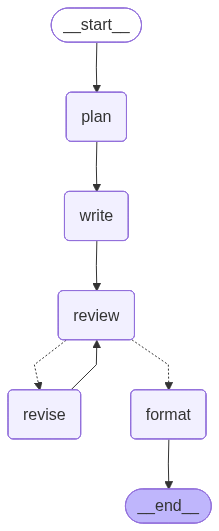

In [17]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
topic = "에이전트 패턴을 매일 세 챕터 씩 공부하는 방법에 대한 보고서 작성"

planner_spec = AgentSpec(
    name="Planner",
    role="전문 계획 수립자",
    goal="효과적인 계획을 수립하여 고품질 요약을 작성하는 것",
    backstory="다양한 주제에 대한 계획 수립 경험이 풍부한 전문가"
)
writer_spec = AgentSpec(
    name="Writer",
    role="숙련된 콘텐츠 작성자",
    goal="명확하고 간결한 요약을 작성하는 것",
    backstory="다양한 주제에 대한 글쓰기 경험이 풍부한 전문가"
)

plan_task = TaskSpec(
    name="Plan Creation",
    description=f"주어진 주제 '{topic}'에 대한 실행 가능한 계획을 수립합니다.",
    expected_output="4-6단계의 명확한 계획"
)
write_task = TaskSpec(
    name="Draft Writing",
    description="수립된 계획을 바탕으로 명확하고 간결한 요약을 작성합니다.",
    expected_output="약 200단어의 요약 초안"
)

result = app.invoke(
    {
        "topic": topic,
        "agents": {
            "planner": planner_spec,
            "writer": writer_spec
        },
        "tasks": {
            "plan_creation": plan_task,
            "draft_writing": write_task
        },
        "need_plan_approval": False,
        "max_revisions": 2,
        "revision_count": 0,
        "plan": [],
        "draft": "",
        "critique": None,
        "report": "",
        "messages": []
    }
)

print("최종 보고서:\n")
print(result["report"])

최종 보고서:

### 계획
- 1. 주제 분석 및 구조 결정: 에이전트 패턴의 정의, 주요 유형(예: 상태 에이전트, 행동 에이전트), 실제 응용 사례 등을 파악하고, 보고서 구조를 결정합니다.
- 2. 일일 학습 계획 수립: 매일 3개의 챕터를 집중적으로 공부하고, 각 챕터의 핵심 내용, 예시, 그리고 학습 후 정리 노트를 작성하는 방식을 정합니다.
- 3. 학습 자료 확보: 관련 책, 논문, 온라인 자료 등을 수집하여 매일 학습에 활용할 수 있도록 준비합니다.
- 4. 정리 및 요약: 매일 학습 후, 해당 챕터의 핵심 내용을 간결하게 요약하고, 정리 노트를 작성하여 이해도를 높입니다.
- 5. 주기적 검토 및 피드백: 주간 또는 매주 첫날에 학습 내용을 검토하고, 필요시 추가 학습 또는 수정을 진행합니다.
- 6. 보고서 작성 및 정리: 모든 챕터를 학습하고 정리한 후, 보고서를 작성하고, 내용을 체계적으로 정리하여 최종 결과물을 제출합니다.

### 요약
에이전트 패턴을 매일 3개의 챕터씩 공부하는 방법에 대한 보고서는 구조화된 학습 접근법을 통해 효율적으로 진행할 수 있습니다. 첫 단계에서는 에이전트 패턴의 정의, 주요 유형, 실제 응용 사례 등을 분석하고, 보고서 구조를 결정합니다. 다음으로 일일 학습 계획을 수립하여 매일 3개의 챕터를 집중적으로 공부하고, 핵심 내용, 예시, 정리 노트를 작성합니다. 관련 자료를 확보하고, 매일 학습 후 요약 및 정리 노트를 통해 이해도를 높입니다. 주간 검토를 통해 내용을 정리하고, 필요시 추가 학습을 진행합니다. 마지막으로 모든 챕터를 학습한 후 보고서를 체계적으로 작성하여 결과물을 제출합니다. 이 방법은 지속적인 학습과 정리을 통해 에이전트 패턴에 대한 깊은 이해를 도모합니다.


# Google DeepResearch

사용자가 던진 질문을 단순히 검색하는 게 아니라, 스스로 연구 계획을 세우고 실행하는 시스템이다.  
기존의 단일 질의-응답형 검색과 달리, **복잡한 주제를 체계적으로 탐구하고 종합하는 자동 연구 에이전트**이다.

## 작동 구조
1. 프롬프트 분석 → 사용자의 질문을 세분화해서 multi-point research plan(다항목 연구 계획)을 만든다.
2. 계획 검토 단계 → 사용자가 이 계획을 보고 수정하거나 승인할 수 있다. → 사용자와 협업하는 플래닝 시스템이다.
3. 반복적 탐색 루프 실행 → 계획이 승인되면 에이전트가 Google 검색을 반복 수행하며, 매 단계마다
    - 새로운 쿼리를 동적으로 작성
    - **정보의 공백(knowledge gaps)**을 파악
    - 데이터 검증(corroboration) 및 불일치 해결(discrepancy resolution)

이 과정 전체는 단일 질의-응답이 아닌 **관리된 장기 실행 프로세스(long-running process)**로 운영된다.

## 설계적 특징
- 비동기(asynchronous) 구조 → 수백 개의 소스를 분석해도 단일 장애에 견딤
- 사용자 알림 시스템 → 실행 중 사용자는 이탈(disengage) 가능, 완료 시 통보
- 문서 통합 기능 → 사용자가 제공한 개인 문서와 웹 데이터를 함께 분석

## 결과물 (Output)
- 단순 요약이 아니라 **구조화된 다중 페이지 보고서(structured multi-page report)**
- **비판적 평가(critical evaluation)**를 통해 주요 주제 도출
- **논리적 섹션(logical sections)**으로 정리된 흐름이 자연스러운 이야기 구조(coherent narrative)  
  → 단순 정보 나열이 아니라 주제 간 인과관계와 논리 흐름을 드러냄
- 상호작용형 보고서 : 오디오 요약, 차트, 원본 인용 링크 포함
- 투명성 보장 : 검색·참조한 모든 출처를 명시 (그림 2 참고)

## 핵심 가치
수작업으로 데이터를 수집하고 정리하는 과정을 자동화하여,  
**더 넓고 깊은 정보 탐색을 빠르게 수행**하고,  
사용자가 **전략적 해석과 의사결정에 집중**할 수 있도록 지원한다.

In [6]:
import os
import dotenv
from google import genai

dotenv.load_dotenv()

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Google GenAI SDK의 무료 등급: 무료 한도"
)
print(response.text)


Google GenAI SDK는 Google의 생성형 AI 모델(예: Gemini)에 접근하기 위한 클라이언트 라이브러리이며, 이 SDK를 통해 접근하는 서비스에는 일반적으로 무료 등급(Free Tier)이 제공됩니다. 하지만 "무료 한도"는 **어떤 방식으로 Google의 GenAI 서비스를 이용하느냐**에 따라 다소 차이가 있습니다.

주로 두 가지 주요 접근 방식이 있습니다:

1.  **Google AI Studio (이전 MakerSuite) / Gemini API 직접 이용:**
    *   이것은 개발자가 빠르게 프로토타이핑하고 앱을 구축할 수 있도록 설계된 서비스입니다.
    *   **특징:**
        *   별도의 Google Cloud 계정 없이 Google 계정으로 접근 가능합니다.
        *   주로 개인 프로젝트, 학습, 소규모 애플리케이션 개발에 적합합니다.
        *   **무료 한도:** 일반적으로 **매우 관대한 무료 사용량**을 제공합니다. 이는 보통 월별 또는 분당 특정 수의 요청 및 토큰(입력/출력)으로 측정됩니다. 정확한 수치는 Google의 정책에 따라 변경될 수 있으므로, 항상 최신 정보를 확인해야 합니다.
        *   **예시 (과거 또는 일반적인 수준):**
            *   특정 모델에 대해 분당 수십 ~ 수백 회의 요청.
            *   월별 수십만 ~ 수백만 개의 토큰 사용량.
        *   **장점:** 시작하기 매우 쉽고, 비용 걱정 없이 실험하기 좋습니다.
        *   **단점:** 엔터프라이즈 기능(고급 보안, VPC 네트워크 통합 등)은 제한적입니다.
    *   **공식 문서 확인:** Google AI Studio 또는 Gemini API 문서를 통해 최신 무료 한도를 확인해야 합니다.

2.  **Google Cloud Vertex AI 플랫폼을 통한 GenAI 이용:**
    *   이것은 기업 및 대규모 프로덕션 환

https://github.com/google-gemini/gemini-fullstack-langgraph-quickstart/tree/main/backend

LangGraph 에이전트의 상태 관리를 위한 여러 TypedDict 클래스

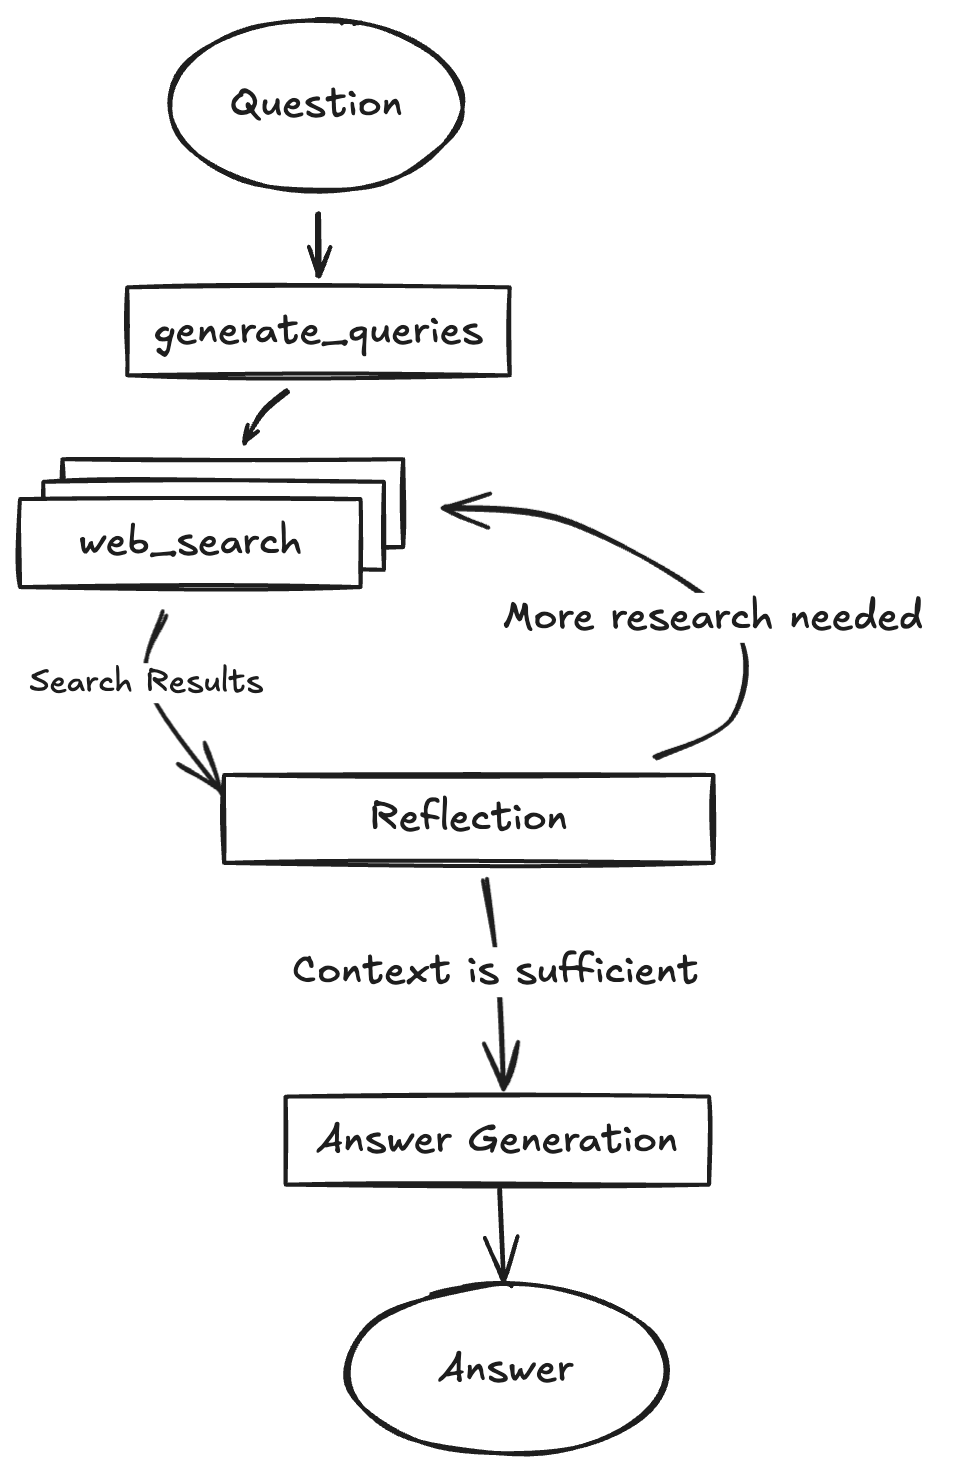

In [ ]:
from __future__ import annotations


from dataclasses import dataclass, field
from typing import TypedDict

from langgraph.graph import add_messages
from typing_extensions import Annotated

import operator

class OverallState(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: Annotated[list, operator.add]
    web_research_result: Annotated[list, operator.add]
    sources_gathered: Annotated[list, operator.add]
    initial_search_query_count: int
    max_research_loops: int
    research_loop_count: int
    reasoning_model: str


class ReflectionState(TypedDict):
    is_sufficient: bool
    knowledge_gap: str
    follow_up_queries: Annotated[list, operator.add]
    research_loop_count: int
    number_of_ran_queries: int


class Query(TypedDict):
    query: str
    rationale: str


class QueryGenerationState(TypedDict):
    search_query: list[Query]


class WebSearchState(TypedDict):
    search_query: str
    id: str


@dataclass(kw_only=True)
class SearchStateOutput:
    running_summary: str = field(default=None) # Final report

에이전트의 설정값

In [ ]:
import os
from pydantic import BaseModel, Field
from typing import Any, Optional

from langchain_core.runnables import RunnableConfig


class Configuration(BaseModel):
    query_generator_model: str = Field(
        default="gemini-2.5-flash",
        description="에이전트의 쿼리 생성에 사용할 언어 모델의 이름"
    )

    reflection_model: str = Field(
        default="gemini-2.5-flash",
        description="에이전트의 반성(평가) 과정에 사용할 언어 모델의 이름"
    )

    answer_model: str = Field(
        default="gemini-2.5-flash",
        description="에이전트의 답변 생성에 사용할 언어 모델의 이름"
    )

    number_of_initial_queries: int = Field(
        default=3,
        description="생성할 초기 검색 쿼리의 수"
    )

    max_research_loops: int = Field(
        default=2,
        description="수행할 최대 연구 루프 수"
    )

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":

        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )

        raw_values: dict[str, Any] = {
            name: os.environ.get(name.upper(), configurable.get(name))
            for name in cls.model_fields.keys()
        }

        values = {k: v for k, v in raw_values.items() if v is not None}

        return cls(**values)


In [30]:
from datetime import datetime
from typing import Any, Dict, List

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage


def get_current_date():
    return datetime.now().strftime("%B %d, %Y")


def get_research_topic(messages: List[AnyMessage]) -> str:
    if len(messages) == 1:
        research_topic = messages[-1].content
    else:
        research_topic = ""
        for message in messages:
            if isinstance(message, HumanMessage):
                research_topic += f"User: {message.content}\n"
            elif isinstance(message, AIMessage):
                research_topic += f"Assistant: {message.content}\n"
    return research_topic


class SearchQueryList(BaseModel):
    query: List[str] = Field(
        description="웹 리서치에 사용할 검색 쿼리 목록"
    )
    rationale: str = Field(
        description="이 쿼리들이 연구 주제와 관련이 있는 이유에 대한 간단한 설명"
    )


class Reflection(BaseModel):
    is_sufficient: bool = Field(
        description="제공된 요약이 사용자의 질문에 답하기에 충분한지 여부"
    )
    knowledge_gap: str = Field(
        description="누락되었거나 명확히 해야할 정보에 대한 설명"
    )
    follow_up_queries: List[str] = Field(
        description="지식 격차를 해결하기 위한 후속 쿼리 목록"
    )


def generate_query(state: OverallState, config: RunnableConfig) -> QueryGenerationState:
    configurable = Configuration.from_runnable_config(config)

    if state.get("initial_search_query_count") is None:
        state["initial_search_query_count"] = configurable.number_of_initial_queries

    llm = ChatGoogleGenerativeAI(
        model=configurable.query_generator_model,
        temperature=1.0,
        max_retries=2,
        api_key=os.getenv("GEMINI_API_KEY")
    )
    structured_llm = llm.with_structured_output(SearchQueryList)

    query_writer_instructions = """당신의 목표는 정교하고 다양한 웹 검색 쿼리를 생성하는 것입니다. 이 쿼리들은 복잡한 결과를 분석하고, 링크를 따라가며, 정보를 종합할 수 있는 고급 자동화 웹 연구 도구를 위한 것입니다.

    지침:
    - 항상 단일 검색 쿼리를 선호하되, 원래 질문이 여러 측면이나 요소를 요구하고 하나의 쿼리로는 충분하지 않을 때만 추가 쿼리를 생성하세요.
    - 각 쿼리는 원래 질문의 특정한 한 측면에 집중해야 합니다.
    - {number_queries}개 이상의 쿼리를 생성하지 마세요.
    - 쿼리는 다양해야 하며, 주제가 광범위하면 1개 이상의 쿼리를 생성하세요.
    - 유사한 쿼리를 여러 개 생성하지 마세요. 1개면 충분합니다.
    - 쿼리는 가장 최신 정보를 수집할 수 있도록 해야 합니다. 현재 날짜는 {current_date}입니다.

    형식:
    - 다음 두 키를 모두 포함하는 JSON 객체로 응답을 형식화하세요:
    - "rationale": 이 쿼리들이 관련성이 있는 이유에 대한 간단한 설명
    - "query": 검색 쿼리 목록

    예시:

    주제: 작년에 애플 주식과 아이폰 구매자 수 중 어느 것의 수익이 더 많이 증가했는가
    ```json
    {{
        "rationale": "이 비교 성장 질문에 정확히 답하기 위해서는 애플의 주식 성과와 아이폰 판매 지표에 대한 구체적인 데이터 포인트가 필요합니다. 이 쿼리들은 직접 비교를 위해 필요한 정확한 재무 정보를 대상으로 합니다: 회사 수익 동향, 제품별 판매량 수치, 그리고 같은 회계 기간 동안의 주가 움직임.",
        "query": ["Apple total revenue growth fiscal year 2024", "iPhone unit sales growth fiscal year 2024", "Apple stock price growth fiscal year 2024"],
    }}
    ```

    맥락: {research_topic}"""

    formatted_prompt = query_writer_instructions.format(
        current_date=get_current_date(),
        number_queries=state["initial_search_query_count"],
        research_topic=get_research_topic(state["messages"])
    )
    result = structured_llm.invoke(formatted_prompt)
    return {"search_query": result.query}


In [31]:
import os

from langgraph.types import Send
from google.genai import Client


genai_client = Client(api_key=os.getenv("GEMINI_API_KEY"))


def continue_to_web_research(state: QueryGenerationState):
    """웹 리서치 노드로 검색 쿼리를 전송하는 헬퍼 함수
    """

    return [
        Send("web_research", {"search_query": search_query, "id": int(idx)})
        for idx, search_query in enumerate(state["search_query"])
    ]


def resolve_urls(urls_to_resolve: List[Any], id: int) -> Dict[str, str]:
    """URL을 고유한 식별자로 매핑하는 헬퍼 함수    """
    prefix = f"https://vertexaisearch.cloud.google.com/id/"
    urls = [site.web.uri for site in urls_to_resolve]

    resolved_map = {}
    for idx, url in enumerate(urls):
        if url not in resolved_map:
            resolved_map[url] = f"{prefix}{id}-{idx}"

    return resolved_map


def get_citations(response, resolved_urls_map):
    citations = []

    if not response or not response.candidates:
        return citations

    candidate = response.candidates[0]
    if (
        not hasattr(candidate, "grounding_metadata")
        or not candidate.grounding_metadata
        or not hasattr(candidate.grounding_metadata, "grounding_supports")
    ):
        return citations

    for support in candidate.grounding_metadata.grounding_supports:
        citation = {}

        if not hasattr(support, "segment") or support.segment is None:
            continue

        start_index = (
            support.segment.start_index
            if support.segment.start_index is not None
            else 0
        )

        if support.segment.end_index is None:
            continue

        citation["start_index"] = start_index
        citation["end_index"] = support.segment.end_index

        citation["segments"] = []
        if (
            hasattr(support, "grounding_chunk_indices")
            and support.grounding_chunk_indices
        ):
            for ind in support.grounding_chunk_indices:
                try:
                    chunk = candidate.grounding_metadata.grounding_chunks[ind]
                    resolved_url = resolved_urls_map.get(chunk.web.uri, None)
                    citation["segments"].append(
                        {
                            "label": chunk.web.title.split(".")[:-1][0],
                            "short_url": resolved_url,
                            "value": chunk.web.uri,
                        }
                    )
                except (IndexError, AttributeError, NameError):
                    pass
        citations.append(citation)
    return citations


def insert_citation_markers(text, citations_list):
    sorted_citations = sorted(
        citations_list, key=lambda c: (c["end_index"], c["start_index"]), reverse=True
    )

    modified_text = text
    for citation_info in sorted_citations:
        end_idx = citation_info["end_index"]
        marker_to_insert = ""
        for segment in citation_info["segments"]:
            marker_to_insert += f" [{segment['label']}]({segment['short_url']})"
        modified_text = (
            modified_text[:end_idx] + marker_to_insert + modified_text[end_idx:]
        )

    return modified_text



def web_research(state: WebSearchState, config: RunnableConfig) -> OverallState:
    configurable = Configuration.from_runnable_config(config)

    web_searcher_instructions = """"{research_topic}"에 대한 가장 최신의 신뢰할 수 있는 정보를 수집하기 위해 타겟팅된 Google 검색을 수행하고, 이를 검증 가능한 텍스트 결과물로 종합하세요.

    지침:
    - 쿼리는 가장 최신 정보를 수집할 수 있도록 해야 합니다. 현재 날짜는 {current_date}입니다.
    - 포괄적인 정보를 수집하기 위해 다양하고 여러 번의 검색을 수행하세요.
    - 각 특정 정보에 대한 출처를 꼼꼼히 추적하면서 핵심 발견사항을 통합하세요.
    - 출력은 검색 결과를 바탕으로 한 잘 작성된 요약 또는 보고서여야 합니다.
    - 검색 결과에서 발견된 정보만 포함하고, 어떤 정보도 지어내지 마세요.

    연구 주제:
    {research_topic}
    """

    formatted_prompt = web_searcher_instructions.format(
        current_date=get_current_date(),
        research_topic=state["search_query"])

    # 제미나이 클라이언트를 langchain 클라이언트 대신 사용 ( 근거 메타데이터 반환 )
    response = genai_client.models.generate_content(
        model=configurable.query_generator_model,
        contents=formatted_prompt,
        config={
            "tools": [{"google_search": {}}],
            "temperature": 0,
        },
    )

    resolved_urls = resolve_urls(
        response.candidates[0].grounding_metadata.grounding_chunks, state["id"]
    )

    citations = get_citations(response, resolved_urls)
    modified_text = insert_citation_markers(response.text, citations)
    sources_gathered = [item for citation in citations for item in citation["segments"]]

    return {
        "sources_gathered": sources_gathered,
        "search_query": [state["search_query"]],
        "web_research_result": [modified_text],
    }


In [32]:
class Reflection(BaseModel):
    is_sufficient: bool = Field(
        description="제공된 요약이 사용자의 질문에 답하기에 충분한지 여부"
    )
    knowledge_gap: str = Field(
        description="누락되었거나 명확히 해야할 정보에 대한 설명"
    )
    follow_up_queries: List[str] = Field(
        description="지식 격차를 해결하기 위한 후속 쿼리 목록"
    )



def reflection(state: OverallState, config: RunnableConfig) -> ReflectionState:
    configurable = Configuration.from_runnable_config(config)
    state["research_loop_count"] = state.get("research_loop_count", 0) + 1
    reasoning_model = state.get("reasoning_model", configurable.reflection_model)

    current_date = get_current_date()

    reflection_instructions = """당신은 "{research_topic}"에 대한 요약을 분석하는 전문 연구 보조원입니다.

    지침:
    - 지식 격차나 더 깊은 탐구가 필요한 영역을 식별하고 후속 쿼리를 생성하세요. (1개 또는 여러 개)
    - 제공된 요약이 사용자의 질문에 답하기에 충분하다면, 후속 쿼리를 생성하지 마세요.
    - 지식 격차가 있다면, 이해를 확장하는 데 도움이 될 후속 쿼리를 생성하세요.
    - 완전히 다루어지지 않은 기술적 세부사항, 구현 사양 또는 새로운 트렌드에 집중하세요.

    요구사항:
    - 후속 쿼리가 독립적이며 웹 검색에 필요한 맥락을 포함하도록 하세요.

    출력 형식:
    - 다음의 정확한 키를 가진 JSON 객체로 응답을 형식화하세요:
    - "is_sufficient": true 또는 false
    - "knowledge_gap": 누락되었거나 명확히 해야 할 정보를 설명
    - "follow_up_queries": 이 격차를 해결하기 위한 구체적인 질문 작성

    예시:
    ```json
    {{
        "is_sufficient": true, // 또는 false
        "knowledge_gap": "요약에 성능 지표와 벤치마크에 대한 정보가 부족합니다", // is_sufficient가 true이면 ""
        "follow_up_queries": ["[특정 기술]을 평가하는 데 사용되는 일반적인 성능 벤치마크와 지표는 무엇인가요?"] // is_sufficient가 true이면 []
    }}
    ```

    요약을 신중히 검토하여 지식 격차를 식별하고 후속 쿼리를 생성하세요. 그런 다음 이 JSON 형식에 따라 출력을 생성하세요:

    요약:
    {summaries}
    """

    formatted_prompt = reflection_instructions.format(
        current_date=current_date,
        research_topic=get_research_topic(state["messages"]),
        summaries="\n\n---\n\n".join(state["web_research_result"]),
    )
    llm = ChatGoogleGenerativeAI(
        model=reasoning_model,
        temperature=1.0,
        max_retries=2,
        api_key=os.getenv("GEMINI_API_KEY")
    )
    result = llm.with_structured_output(Reflection).invoke(formatted_prompt)

    return {
        "is_sufficient": result.is_sufficient,
        "knowledge_gap": result.knowledge_gap,
        "follow_up_queries": result.follow_up_queries,
        "research_loop_count": state["research_loop_count"],
        "number_of_ran_queries": len(state["search_query"])
    }

In [33]:
def evaluate_research(
    state: ReflectionState,
    config: RunnableConfig,
) -> OverallState:
    configurable = Configuration.from_runnable_config(config)
    max_research_loops = (
        state.get("max_research_loops")
        if state.get("max_research_loops") is not None
        else configurable.max_research_loops
    )
    if state["is_sufficient"] or state["research_loop_count"] >= max_research_loops:
        return "finalize_answer"
    else:
        return [
            Send(
                "web_research",
                {
                    "search_query": follow_up_query,
                    "id": state["number_of_ran_queries"] + int(idx)
                },
            )
            for idx, follow_up_query in enumerate(state["follow_up_queries"])
        ]

In [34]:
def finalize_answer(state: OverallState, config: RunnableConfig):
    configurable = Configuration.from_runnable_config(config)
    reasoning_model = state.get("reasoning_model") or configurable.answer_model

    current_date = get_current_date()
    answer_instructions = """제공된 요약을 바탕으로 사용자의 질문에 대한 고품질 답변을 생성하세요.

    지침:
    - 현재 날짜는 {current_date}입니다.
    - 당신은 다단계 연구 프로세스의 마지막 단계입니다. 마지막 단계라는 것을 언급하지 마세요.
    - 이전 단계에서 수집된 모든 정보에 접근할 수 있습니다.
    - 사용자의 질문에 접근할 수 있습니다.
    - 제공된 요약과 사용자의 질문을 바탕으로 고품질 답변을 생성하세요.
    - 요약에서 사용한 출처를 답변에 올바르게 포함하세요. 마크다운 형식을 사용하세요 (예: [apnews](https://vertexaisearch.cloud.google.com/id/1-0)). 이것은 필수입니다.

    사용자 맥락:
    - {research_topic}

    요약:
    {summaries}"""

    formatted_prompt = answer_instructions.format(
        current_date=current_date,
        research_topic=get_research_topic(state["messages"]),
        summaries="\n---\n\n".join(state["web_research_result"]),
    )

    llm = ChatGoogleGenerativeAI(
        model=reasoning_model,
        temperature=1.0,
        max_retries=2,
        api_key=os.getenv("GEMINI_API_KEY")
    )
    result = llm.invoke(formatted_prompt)

    unique_sources = []
    for source in state["sources_gathered"]:
        if source["short_url"] in result.content:
            result.content = result.content.replace(
                source["short_url"], source["value"]
            )
            unique_sources.append(source)

    return {
        "messages": [AIMessage(content=result.content)],
        "sources_gathred": unique_sources,
    }



In [35]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END


builder = StateGraph(OverallState, context_schema=Configuration)

builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("reflection", reflection)
builder.add_node("finalize_answer", finalize_answer)

builder.add_edge(START, "generate_query")
builder.add_conditional_edges(
    "generate_query",
    continue_to_web_research,
    ["web_research"]
)
builder.add_edge("web_research", "reflection")
builder.add_conditional_edges(
    "reflection",
    evaluate_research,
    ["web_research", "finalize_answer"]
)
builder.add_edge("finalize_answer", END)

app = builder.compile(name="web-research-agent")

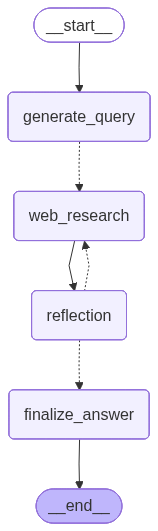

In [36]:
from IPython.display import Image, display


display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
state = {
    # 필수
    "messages": [HumanMessage(content="에이전트 패턴을 매일 세 챕터 씩 공부하는 방법에 대한 보고서 작성")],
    "initial_search_query_count": 3,  # 초기 쿼리 개수
    "max_research_loops": 2,  # 최대 반복 횟수
    "reasoning_model": "gemini-2.5-pro",  # 모델명
}
result = app.invoke(state)

In [38]:
result

{'messages': [HumanMessage(content='에이전트 패턴을 매일 세 챕터 씩 공부하는 방법에 대한 보고서 작성', additional_kwargs={}, response_metadata={}, id='a76d9c27-9fa2-4776-97cd-9e1531cffb7e'),
  AIMessage(content='에이전트 패턴 학습을 위한 보고서: 일일 3챕터 스터디 가이드\n\n에이전트 패턴을 매일 세 챕터씩 체계적으로 학습하기 위한 보고서입니다. 이 가이드는 기초 개념부터 고급 아키텍처 및 실제 구현까지 단계적으로 구성되어 있으며, 각 단계는 심층적인 이해를 돕기 위한 핵심 주제들로 이루어져 있습니다.\n\n### **1단계: AI 에이전트 기초 다지기 (1~2주차)**\n\n첫 주에는 AI 에이전트의 기본 원리와 핵심 디자인 패턴을 이해하는 데 중점을 둡니다.\n\n*   **1일차 (챕터 1-3): AI 에이전트의 기본**\n    *   **챕터 1: AI 에이전트의 정의와 유형:** 에이전트의 기본 개념과 자율성, 반응성, 사회성 등 핵심 특징을 학습합니다. 단순 반사 에이전트부터 학습 에이전트까지 다양한 유형을 이해합니다 [brunch](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEt-xQcI2Qpi5icjpwpmSnJx9z8Dfgl_YuHWlCpDkzMe79rSkVqUFpTqEFoRO0MrZzgPFmLPGqpxgM_H-IQnFW8e3NWeCloAQOHIVR1Ew2-CJBc7fWNDc94awjgf4k=) [tistory](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF97Rw0OjI-njUFFQyHTzJMMnIzcxX5UQzgKRttX1QeDbP9RtDkfAJJoCHZ9K3GCEV7LX2d1yxGGKoNc22UfawMsqOO0-9_jAH_UVBuJxNwtUuaJ-OCYy-pu

# OpenAI Deep Research API

단순 Q&A가 아니라, **현실 세계의 출처를 기반으로 스스로 추론·계획·종합**하여
**구조화되고 인용이 포함된 보고서**를 만들어내는 **프로그래밍 가능(Programmatic)한 연구 에이전트 API**.

## 작동 구조
1. **고수준 질의 입력** → 모델이 질의를 **하위 질문(sub-questions)**으로 자동 분해
2. **계획 실행** → 내장 도구로 **웹 검색(web search)** 수행, 증거(출처) 수집
3. **분석·종합** → 사실 검증 및 상충 정보 조정, **인용 포함** 최종 보고서 생성
4. **프로그램적 제어** → `client.responses.create`로 **전 과정에 직접 접근**(모델/프롬프트/도구 지정)

> 모델 예시(작성 시점):  
> - 고품질 종합: `o3-deep-research-2025-06-26`  
> - 저지연: `o4-mini-deep-research-2025-06-26`

## 설계적 특징
- **Agentic Planning**: 질의를 스스로 쪼개고, 필요한 검색/검증 단계를 **계획-실행**  
- **투명성(Transparency)**: 결과뿐 아니라 **중간 단계(추론 요약, 실행 쿼리, 실행 코드)**를 노출  
- **확장성(Extensibility)**: **MCP(Model Context Protocol)**로 사내 지식베이스/내부 데이터와 연결  
- **도구 기반 실행**: 필수 `web_search_preview`, 선택 `code_interpreter` 및 커스텀 MCP 도구 추가 가능

## 결과물 (Output)
- **구조화된 보고서(structured final report)**: 섹션화/표/차트 가능
- **인라인 인용(citation-rich)**: 본문 내 출처 스팬에 **메타데이터 링크** 연결
- **일관된 내러티브(coherent narrative)**: 논리적 섹션으로 주제를 전개하고 근거를 배치
- **중간 산출물 접근**: 추론 요약, 실제 검색 쿼리, 코드 실행 내역을 **프로그래밍적으로 조회**

## 핵심 가치
- **시간 단축**: 수시간 걸릴 수작업 리서치를 자동화  
- **신뢰성**: **검증 가능한 인용**과 **중간 단계 노출**로 감사/디버깅/재현성 강화  
- **현업 적합성**: 전략/투자/정책 의사결정을 뒷받침하는 **데이터 기반 보고서** 생성  
- **사내 데이터 융합**: MCP로 **공개 웹+내부 정보**를 결합한 심층 리서치 가능

In [ ]:
import os
import base64
from openai import AzureOpenAI

endpoint = os.getenv("ENDPOINT_URL")
deployment = os.getenv("DEPLOYMENT_NAME")
api_key = os.getenv("API_KEY")

client = AzureOpenAI(
    azure_endpoint=endpoint,
    api_key=api_key,
    api_version="2025-04-01-preview",
)

system_message = """You are a professional researcher preparing a structured, data-driven report.
Focus on data-rich insights, use reliable sources, and include inline citations.
"""
user_query = "Research the economic impact of semaglutide on global healthcare systems."


chat_prompt = []

# Include speech result if speech is enabled
messages = chat_prompt

response = client.responses.create(
    model=deployment,
    input=[
        {
            "role": "developer",
            "content": [{"type": "input_text", "text": system_message}]
        },
        {
            "role": "user",
            "content": [{"type": "input_text", "text": user_query}]
        }
    ],
    reasoning={"summary": "auto"},
    tools=[{"type": "web_search_preview"}]
)


In [25]:
import os
import json
import warnings
from pathlib import Path
from datetime import datetime

def save_response(response, outdir="outputs", prefix="response"):
    """
    OpenAI Responses API 응답을 파일로 저장합니다.
    - {prefix}_{YYYYmmdd-HHMMSS}.json : 전체 원시 응답
    - {prefix}_{YYYYmmdd-HHMMSS}.txt  : 생성 텍스트만
    - {prefix}_{YYYYmmdd-HHMMSS}_usage.json : 토큰 사용량 등 요약
    """
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    out = Path(outdir)
    out.mkdir(parents=True, exist_ok=True)

    json_path = out / f"{prefix}_{ts}.json"
    txt_path  = out / f"{prefix}_{ts}.txt"
    usage_path = out / f"{prefix}_{ts}_usage.json"

    # --- 1) 전체 응답 저장 (경고 없이, 임의 객체도 안전 직렬화) ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Pydantic serializer warnings:")
        try:
            # Pydantic 모델이 보장되는 SDK(v1+) 경로
            json_str = response.model_dump_json(
                indent=2,
                ensure_ascii=False,
                warnings=False,
                serialize_as_any=True,  # web_search 등 임의 타입 그대로 직렬화
            )
        except Exception:
            # 구버전/타입 불일치 대비: dict로 변환 후 json.dumps
            try:
                payload = response.model_dump(warnings=False, serialize_as_any=True)
            except Exception:
                # 마지막 안전망: __dict__ 또는 그대로 json.dumps 시도
                payload = getattr(response, "__dict__", response)
            json_str = json.dumps(payload, ensure_ascii=False, indent=2, default=str)

    json_path.write_text(json_str, encoding="utf-8")

    # --- 2) 생성 텍스트만 추출해서 저장 ---
    # responses API일 경우 response.output_text 가 가장 간단
    generated_text = getattr(response, "output_text", None)

    if generated_text is None:
        # 구조가 다를 수 있어 방어적으로 content 트래버스
        generated_text = ""
        try:
            payload = json.loads(json_str)  # 위에서 저장한 직렬화 결과 재활용
            # output -> list[ {content: [ {type, text}, ... ]}, ... ]
            output_items = payload.get("output", []) if isinstance(payload, dict) else []
            parts = []
            for item in output_items:
                for c in item.get("content", []):
                    # responses 규격: type=output_text | text
                    if isinstance(c, dict) and ("text" in c):
                        parts.append(c["text"])
            generated_text = "\n".join(parts).strip()
        except Exception:
            pass

    txt_path.write_text(generated_text or "", encoding="utf-8")

    # --- 3) usage 요약 저장 (있을 때만) ---
    usage_obj = getattr(response, "usage", None)
    usage_payload = None
    if usage_obj is not None:
        try:
            # pydantic 모델일 수 있음
            usage_payload = getattr(usage_obj, "model_dump", lambda **_: usage_obj)(warnings=False, serialize_as_any=True)
        except Exception:
            usage_payload = getattr(usage_obj, "__dict__", None) or usage_obj

    if usage_payload is None:
        # 직렬화된 전체 JSON에서 usage 키를 찾아 저장
        try:
            usage_payload = json.loads(json_str).get("usage")
        except Exception:
            usage_payload = None

    if usage_payload is not None:
        usage_path.write_text(json.dumps(usage_payload, ensure_ascii=False, indent=2, default=str), encoding="utf-8")

    print(f"✅ Saved JSON : {json_path}")
    print(f"✅ Saved text : {txt_path}")
    if usage_payload is not None:
        print(f"✅ Saved usage: {usage_path}")


save_response(response, outdir="outputs", prefix="gemini_response")

✅ Saved JSON : outputs/gemini_response_20251107-151042.json
✅ Saved text : outputs/gemini_response_20251107-151042.txt
✅ Saved usage: outputs/gemini_response_20251107-151042_usage.json


### final report

In [29]:
# Access and print the final report from the response
final_report = response.output[-1].content[0].text
print(final_report)

# Economic Impact of Semaglutide on Global Healthcare Systems

## Background: Semaglutide’s Rise and Global Health Context  
Semaglutide is a glucagon-like peptide-1 (GLP-1) receptor agonist originally developed for type 2 diabetes, now also approved at higher doses for obesity management. It has demonstrated unprecedented efficacy in weight loss, with clinical trials showing average body weight reductions of 12–16% over ~68 weeks ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=for%20a%20maximum%20of%20two,The%202019%20Health%20Survey%20for)) ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=with%20its%20weight,influencers%20and%20public%20figures%20touting)). This dual utility in diabetes control and obesity treatment addresses two major public health challenges. Globally, diabetes and obesity impose enormous economic burdens: annual healthcar

# Economic Impact of Semaglutide on Global Healthcare Systems

## Background: Semaglutide’s Rise and Global Health Context  
Semaglutide is a glucagon-like peptide-1 (GLP-1) receptor agonist originally developed for type 2 diabetes, now also approved at higher doses for obesity management. It has demonstrated unprecedented efficacy in weight loss, with clinical trials showing average body weight reductions of 12–16% over ~68 weeks ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=for%20a%20maximum%20of%20two,The%202019%20Health%20Survey%20for)) ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=with%20its%20weight,influencers%20and%20public%20figures%20touting)). This dual utility in diabetes control and obesity treatment addresses two major public health challenges. Globally, diabetes and obesity impose enormous economic burdens: annual healthcare spending on diabetes soared from **$232 billion in 2007 to $966 billion in 2021** ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=The%20economic%20burden%20of%20type,1RA%29%20semaglutide)), and the world’s economic cost of high BMI is projected to reach **$4.32 trillion per year by 2035** (nearly 3% of global GDP) if current trends continue ([www.bmj.com](https://www.bmj.com/content/380/bmj.p523#:~:text=BMJ%20www,gross%20domestic%20product%E2%80%94annually%20by%202035)). In this context, semaglutide’s notable health benefits have driven explosive demand worldwide – but also raised pressing questions about costs, affordability, and value for healthcare systems.

## Surging Demand and Expenditures  
The advent of semaglutide (branded as Ozempic for diabetes and Wegovy for obesity) has triggered a **skyrocketing surge in spending on GLP-1 drugs**. In the United States alone, spending on GLP-1 receptor agonists climbed to an estimated **$71.7 billion in 2023**, a **500% increase** since 2018 ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=medications%2C%20initially%20developed%20to%20manage,Approved)) ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=practice%20and%20consumer%20spending,levels%20with%20minimal%20side%20effects)). This surge is largely driven by semaglutide-based medications and similar agents like tirzepatide, reflecting both medical innovation and intense consumer demand (amplified by social media hype and off-label weight loss use) ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=The%20popularity%20of%20GLP,government%E2%80%99s)) ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=the%20market,1%20RAs%20and)). Ozempic’s spending grew from just **$0.4 billion in 2018 to $26.4 billion in 2023** in the U.S., while newer products like Wegovy and Mounjaro rapidly captured market share ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=Data%20from%20Symphony%20Health%2C%20analyzed,billion%2C%20as%20newer%20drugs%20dominated)). 

The **unit prices of semaglutide therapies are high**, contributing to this expenditure growth. Typical list prices exceed **$900–$1,300 per month** – for example, Wegovy’s list price is about **$1,349 for a 4-week supply**, and Ozempic about **$968 per pen** (one month’s dose) ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=Cost%20Barrier%20GLP,high%20costs%2C%20some%20economists%20argue)). Such costs translate to over $10,000 per patient annually at list price. Many health insurers cover semaglutide for diabetes, but coverage for obesity is inconsistent (only ~40% of U.S. private plans covered Wegovy for weight loss as of 2023) ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=supply,This%20disparity%20exacerbates%20healthcare)). Consequently, a significant share of patients pay out-of-pocket, underscoring how **semaglutide’s expense can strain personal finances and insurer budgets alike**. Even in public systems, the drug’s cost is substantial; for instance, the UK’s NHS has confidential discounted pricing for Wegovy, but its list price is ~£176 for four weekly 2.4 mg injections ([pharmaphorum.com](https://pharmaphorum.com/news/wegovy-finally-reaches-uk-limited-quantities#:~:text=Wegovy%20finally%20reaches%20the%20UK%2C,although%2C%20one)). Overall, the rapid uptake of semaglutide is **fast becoming a multi-billion-dollar line item** in health expenditures across high-income countries.

## Budgetary Impact and Cost Pressures  
Health economists warn that broad uptake of semaglutide could **strain healthcare budgets** without careful prioritization or price negotiation. The sheer number of eligible patients is enormous – more than 1 billion adults worldwide have obesity (BMI ≥30) ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=list%20of%20keyboard%20shortcuts%20Wealthier,broad%20range%20of%20cardiometabolic%20conditions)), including an estimated 42% of U.S. adults and 28% of English adults ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=less%20and%20reducing%20their%20overall,a%20new%20line%20of%20pharmaceutical)). If even a fraction of these individuals were to use costly GLP-1 therapy long-term, drug spending would balloon. One projection noted that if **about half of U.S. adults with obesity used GLP-1 medications, annual costs could reach $411 billion by 2031**, a figure that would **far exceed current Medicare or private payer drug budgets** ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=spending%20in%20sectors%20like%20fitness%2C,Challenges%20and%20Controversies)). In fact, early analyses by the U.S. Congressional Budget Office estimated that expanding Medicare coverage to anti-obesity drugs would add tens of billions in new spending over a decade ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=disease%20progression%20outweighed%20treatment%20costs,Limitations)). These forecasts have led many payers and governments to approach semaglutide coverage cautiously – targeting the highest-risk patients to maximize impact per dollar. For example, several European countries have limited reimbursement to those with severe obesity and comorbidities, and England’s NICE recommends Wegovy only for adults with **BMI ≥35 plus a weight-related illness (or ≥30 in exceptional cases), for a maximum of two years** under specialist supervision ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=semaglutide%20,clinical%20trial%2C%20a%20randomised%20double)) ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=list%20price%20of%20semaglutide%202,A)). This targeting aims to ensure that the **hefty upfront costs** are justified by substantial health gains in those patients.

Another aspect of budget impact is **the markup between manufacturing cost and price**. Studies suggest semaglutide is relatively inexpensive to produce – a recent analysis in *JAMA Network Open* estimated that **a month’s supply of semaglutide could be manufactured for under $5** ([www.cnbc.com](https://www.cnbc.com/2024/03/27/novo-nordisk-ozempic-can-be-made-for-less-than-5-a-month-study.html#:~:text=Novo%20Nordisk%27s%20Ozempic%20can%20be,month%27s%20supply%20of%20the%20treatment)). Yet the U.S. list price for Ozempic is around **$935–$1,000 per month** ([www.cnbc.com](https://www.cnbc.com/2024/03/27/novo-nordisk-ozempic-can-be-made-for-less-than-5-a-month-study.html#:~:text=Novo%20Nordisk%27s%20list%20price%20for,manufactured%20for%20prices%20far%20below)), implying a **markup on the order of tens of thousands of percent**. Such pricing has made semaglutide a blockbuster revenue source for Novo Nordisk, but it also means payers are footing extremely high bills relative to production costs. *Médecins Sans Frontières* has criticized this “corporate profiteering,” noting that GLP-1 drugs are **sold at ~40,000% above estimated manufacturing cost in the U.S.**, and are essentially **unaffordable or unavailable in many low- and middle-income countries** ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030)) ([www.msfaccess.org](https://www.msfaccess.org/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=...%20www.msfaccess.org%20%20GLP,)). This dynamic places pressure on healthcare systems to negotiate better pricing or await generic competition, especially as the drug class becomes a long-term therapy for chronic conditions.

## Health Outcomes and Cost-Effectiveness  
Despite the high costs, semaglutide offers significant health benefits that can translate into economic value over time. By improving glycemic control and inducing weight loss, it helps prevent downstream complications of diabetes and obesity – complications that are very costly to manage (e.g. heart attacks, strokes, renal failure, joint replacements). Health economic evaluations increasingly find that **semaglutide can be cost-effective, or even cost-saving, in certain contexts** ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses)) ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=Health,case%20net)). 

For instance, a 2025 systematic review in *Diabetes Care* analyzed dozens of studies and found semaglutide was **considered cost-effective in ~74% of comparisons against other glucose-lowering drugs for type 2 diabetes** ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses)). Notably, longer-term and broader-perspective analyses (accounting for lifetime health system costs) tend to favor semaglutide’s value, especially in high-income countries ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=dominant%2Fcost,pay)). The drug’s superior efficacy in reducing HbA1c, body weight, and even cardiovascular risk factors yields more quality-adjusted life years (QALYs) relative to older treatments ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=second,since%202021%2C%20necessitating%20an%20updated)). However, results can vary by assumptions – for example, industry-sponsored models universally found semaglutide cost-effective, whereas independent studies were split, reflecting different views on future cost offsets ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses)).

Cost-effectiveness in **obesity treatment** is more nuanced and depends on the comparator. Semaglutide 2.4 mg produces greater weight loss and health improvements than lifestyle changes or older obesity drugs, but it also incurs much higher drug costs ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=and%20exclusion%20criteria,systematic%20review%20showed%20that%20semaglutide)). A recent systematic review of economic studies in obesity noted that **semaglutide yields more QALYs but at substantially higher lifetime costs** compared to alternatives ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=and%20exclusion%20criteria,systematic%20review%20showed%20that%20semaglutide)). In one modeling example for class I obesity (BMI ~33), total lifetime medical costs were estimated at **$370,776 with semaglutide** therapy versus roughly **$125,000–$140,000** with intensive lifestyle intervention or bariatric procedures ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=conventional%20interventions%20in%20patients%20with,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric)). Consequently, semaglutide’s **incremental cost-effectiveness ratios (ICERs)** sometimes exceed common willingness-to-pay thresholds in obesity, especially against highly effective interventions like gastric sleeve surgery ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=intervention%20,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric)) ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=the%20comprehensive%20management%20of%20type,the%20management%20and%20treatment%20of)). The review concluded that semaglutide **appears cost-effective versus lifestyle-only management and versus a daily GLP-1 like liraglutide**, but **is not cost-effective versus bariatric surgery at current prices** ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=the%20comprehensive%20management%20of%20type,the%20management%20and%20treatment%20of)). These findings underscore that the drug’s value for money is strongly tied to its price and the alternatives available – if semaglutide’s price declines (or if surgery is not accessible), its cost-effectiveness improves. Indeed, analysts note that with “substantial price reduction” semaglutide could become a dominant option for wider obesity populations ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=respectively,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric)).

## Long-Term Savings Through Avoided Health Costs  
Crucially, semaglutide’s **impact on hard outcomes** – cardiovascular events, kidney disease, etc. – may offer long-term savings to healthcare systems by reducing expensive acute care and procedures. A **landmark economic analysis** published in *Value in Health* (October 2025) modeled the effect of comprehensive semaglutide access in U.S. Medicare over 10 years. The results predicted **major health gains** for seniors: an estimated **38,950 fewer cardiovascular events** (including ~3,800 heart-related deaths), plus **2,330 fewer kidney failure deaths**, **1,820 fewer new sleep apnea cases**, and even **7,900 fewer knee replacement surgeries** compared to a scenario with no semaglutide ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,02%20billion%20while)) ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=beginning%20in%202027,The%20most%20pronounced%20cost)). These improvements stem from better weight and diabetes control across populations with obesity, type 2 diabetes, or related conditions. Importantly, the downstream cost savings from averting these events **offset the drug’s expenses** in the model. Under base-case assumptions (including a modest 10–20% price discount from forthcoming Medicare negotiations), broad semaglutide coverage in Medicare was projected to yield **net savings of about $715 million over 10 years** ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for)) ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=%5BMASH%5D,in%20savings%20with%20a%2020)). In other words, the **$4.44 billion in added treatment costs** would be outweighed by about **$5.15 billion in avoided healthcare costs** (e.g. fewer hospitalizations, dialysis, surgeries) ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=approximately%206180%20fewer%20deaths%20,02%20billion%20under%20alternative)). 

Even in less optimistic scenarios, the Medicare study found a **consistent trend toward cost neutrality or savings**. Across various uptake rates, net savings ranged from **$412 million up to $1.02 billion** over ten years ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=savings%20over%2010%20years,The%20findings%20contrast%20with)). With larger price concessions – e.g. a 20% price cut or eventual generic entry (anticipated by 2032) – the modeled savings rose further, reaching **$1.04–$1.71 billion** in the decade ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for)) ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=%2428%20million,exclusivity%20and%20generic%20entry%20The)). Notably, the analysis showed that covering semaglutide for **obesity alone** (in people without diabetes) might *slightly increase* short-term spending, but when accounting for the reduced incidence of diabetes and cardiovascular disease in that group, even obesity treatment **pays for itself in the long run** ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=maintaining%20major%20cardiovascular%20and%20renal,condition%20benefits.%20The%20present)) ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=billion%20in%20disease,The%20authors%20utilized)). These findings contrast with earlier projections that considered only drug costs: by integrating multi-condition benefits, semaglutide was reframed as a **“net value generator rather than a cost driver”** for insurers ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=disease%20progression%20outweighed%20treatment%20costs,Limitations)) ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=reduced%20diabetes%20incidence%20and%20comorbidity,insulin%20use%20or%20lower%20bariatric)). In summary, if health systems take a long-term view, investing in semaglutide can yield **significant clinical dividends and alleviate future healthcare expenditures** – especially for populations at high risk of expensive complications.

## Global Access Disparities and Challenges  
While semaglutide’s health-economic promise is compelling, there is a stark **global disparity in access** to this medication. High-income countries (HICs) are currently the primary consumers, whereas **lower- and middle-income countries (LMICs) have minimal access** due to cost and supply constraints ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030)) ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=public%20health%20interventions%20focused%20on,analysis%20suggests%20that%20over%20140)). This gap is troubling because obesity and diabetes are rising rapidly in LMICs – it’s projected that **79% of adults with obesity will live in LMICs by 2035** ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=associated%20with%20cardiovascular%20conditions%20and,taken%20seriously%3F%20In%20addition%20to)). Yet in those regions, semaglutide is often unavailable through public health systems and is **far too expensive for most patients out-of-pocket**. The **markup** issue noted earlier plays a big role here: for example, in the U.S. or Europe a monthly course costs roughly a thousand dollars, an amount utterly unfeasible in countries where health budgets and incomes are much lower. *Doctors Without Borders* reports that **GLP-1 drugs like Ozempic remain essentially absent from most low-income countries** in large part because of their price ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030)) ([www.msfaccess.org](https://www.msfaccess.org/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=...%20www.msfaccess.org%20%20GLP,)). This means the **majority of the world’s population** at risk of obesity-related disease is currently left behind from this pharmacological advance – a serious equity concern.

Even within wealthy countries, **demand has outstripped supply**, creating **logistical and ethical challenges**. Semaglutide’s popularity led to global shortages starting in 2022–2023, as the manufacturer struggled to scale production. This has had ripple effects: a 2023 investigation in the UK uncovered **widespread black-market sales of semaglutide** (via social media and even salons), as desperate consumers sought the drug outside official channels ([www.thelancet.com](https://www.thelancet.com/journals/landia/article/PIIS2213-8587(24)00376-0/fulltext#:~:text=This%20practice%2C%20which%20has%20resulted,some%20beauty%20salons%20in%20England)). Such unregulated use raises safety issues and reflects the intense pressure on formal healthcare systems to respond to demand. Meanwhile, healthcare providers must manage expectations and ensure appropriate use – reinforcing lifestyle interventions and reserving medication for those who will benefit medically. 

**Policymakers worldwide are grappling** with how to integrate costly anti-obesity drugs into public health strategies. Thus far, many HICs have adopted a **phased or selective approach**. The United States recently moved toward expanded coverage for weight-loss drugs in Medicare, negotiating price discounts in exchange ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,across%20utilization%20rates%20consistently%20favored)). In Europe, countries like **England and Denmark initially limit semaglutide prescriptions to specialist weight management clinics** and severe cases ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=semaglutide%20,clinical%20trial%2C%20a%20randomised%20double)) ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=list%20price%20of%20semaglutide%202,A)). Notably, the UK’s NHS made a deal with Eli Lilly to roll out tirzepatide (a similar GLP-1/GIP agonist) for up to **220,000 high-risk patients over three years** – starting with those who have a **BMI over 40 plus multiple comorbidities** ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=playbook%20for%20healthcare%20system,ensure%20the%20required%20level%20of)). This pilot aims to target those most likely to avoid expensive healthcare events, and to gather real-world evidence on outcomes and cost-benefit. Such examples serve as **emerging models for coverage**: prioritize the sickest patients first, monitor results, and gradually broaden access if proven cost-effective and if budgets allow.

## Future Outlook: Balancing Cost and Benefit  
The economic impact of semaglutide on global healthcare systems will ultimately depend on how effectively we balance its **considerable upfront costs against its downstream benefits**. In the near term, the **financial burden is significant** – payers are spending billions on these drugs, prompting concerns about sustainability. However, the evidence is growing that semaglutide can **pay for itself by preventing costly diseases**, especially when targeting populations at elevated risk (e.g. patients with diabetes or established cardiovascular disease). Health systems that invest in these treatments may see reduced expenditures on heart attacks, dialysis, orthopedic surgeries, and other complications within a decade ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,02%20billion%20while)) ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for)). From a macroeconomic perspective, widespread effective obesity treatment could also boost productivity and labor participation by improving population health (obesity-related illness costs economies in lost output as well).

Key factors will shape the future impact: **pricing and competition** are foremost. As patent exclusivity lapses (semaglutide could face generic versions in some markets by 2026–2032 ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=case%20assumptions%2C%20semaglutide%20access%20would,across%20utilization%20rates%20consistently%20favored)) ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=development%20for%20the%20treatment%20of,insurance%20schemes%2C%20particularly%20when%20more))) and as new competitors (including oral GLP-1 pills and other weight-loss drugs) emerge, prices may decline. Even a 20% negotiated price reduction substantially improved the cost savings in modeling studies ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for)). Robust generic/biosimilar competition could gradually bring yearly treatment costs from five figures down to more affordable levels, enabling broader global use. Additionally, **innovative financing strategies** might mitigate the budget impact – for example, outcomes-based contracts where payers pay less if patients don’t achieve certain health targets, or government subsidy programs recognizing obesity treatment as an investment in public health.

In conclusion, semaglutide represents a **paradigm shift**: a drug that can significantly reduce the burden of obesity and diabetes, potentially saving healthcare systems money in the long run, yet whose high price today poses a challenge for budgets and equitable access. The **economic impact is two-fold** – there is a **short-term cost surge** as health systems adopt this expensive therapy, but there is also the promise of **long-term economic gains** from a healthier population with fewer expensive chronic conditions. Global healthcare systems are in the process of negotiating this trade-off. With data-driven policies (like careful patient selection, price negotiations, and ongoing cost-effectiveness evaluation), many countries are finding that semaglutide can be a **high-value intervention**. However, extending those benefits worldwide will require addressing affordability for LMICs and ensuring supply meets demand. If these issues are managed, semaglutide and similar GLP-1 therapies could play a pivotal role in bending the curve of obesity- and diabetes-related costs that are projected to reach **trillions of dollars** in coming decades ([www.bmj.com](https://www.bmj.com/content/380/bmj.p523#:~:text=BMJ%20www,gross%20domestic%20product%E2%80%94annually%20by%202035)). In summary, semaglutide’s emergence is **economically impactful**: it is reshaping drug spending patterns and budget priorities, but it also offers an unprecedented opportunity to **reduce the healthcare and societal costs** of two global epidemics. The challenge for global healthcare systems is to harness its benefits in a **sustainable and equitable** way ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=public%20health%20interventions%20focused%20on,analysis%20suggests%20that%20over%20140)) ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030)). 



### citations

In [ ]:
annotations = response.output[-1].content[0].annotations

if not annotations:
    print("No annotations found in the response.")
else:
    for i, citation in enumerate(annotations):
        cited_text = final_report[citation.start_index:citation.end_index]

        print(f"Citation {i+1}:")
        print(f" Cited Text: {cited_text}")
        print(f" Title: {citation.title}")
        print(f" URL: {citation.url}")
        print(f" Location: chars {citation.start_index}-{citation.end_index}")
        print("\n" + "="*50 + "\n")

Citation 1:
 Cited Text: ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=for%20a%20maximum%20of%20two,The%202019%20Health%20Survey%20for))
 Title: NICE recommends new drug for people living with obesity
 URL: https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=for%20a%20maximum%20of%20two,The%202019%20Health%20Survey%20for
 Location: chars 435-625


Citation 2:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=with%20its%20weight,influencers%20and%20public%20figures%20touting))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=with%20its%20weight,influencers%20and%20public%20figures%20touting
 Location: chars 626-811


Citation 3:
 Cited Text: ([diabetesjournals.org](

1. Reasoning Steps: Internal plans and summaries generated by the model.

Citation 1:
 Cited Text: ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=for%20a%20maximum%20of%20two,The%202019%20Health%20Survey%20for))
 Title: NICE recommends new drug for people living with obesity
 URL: https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=for%20a%20maximum%20of%20two,The%202019%20Health%20Survey%20for
 Location: chars 435-625

==================================================

Citation 2:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=with%20its%20weight,influencers%20and%20public%20figures%20touting))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=with%20its%20weight,influencers%20and%20public%20figures%20touting
 Location: chars 626-811

==================================================

Citation 3:
 Cited Text: ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=The%20economic%20burden%20of%20type,1RA%29%20semaglutide))
 Title: Cost-effectiveness of Semaglutide Compared With Other Glucose-Lowering ...
 URL: https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=The%20economic%20burden%20of%20type,1RA%29%20semaglutide
 Location: chars 1084-1281

==================================================

Citation 4:
 Cited Text: ([www.bmj.com](https://www.bmj.com/content/380/bmj.p523#:~:text=BMJ%20www,gross%20domestic%20product%E2%80%94annually%20by%202035))
 Title: Global cost of overweight and obesity will hit $4.32tn a year ... - The BMJ
 URL: https://www.bmj.com/content/380/bmj.p523#:~:text=BMJ%20www,gross%20domestic%20product%E2%80%94annually%20by%202035
 Location: chars 1436-1567

==================================================

Citation 5:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=medications%2C%20initially%20developed%20to%20manage,Approved))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=medications%2C%20initially%20developed%20to%20manage,Approved
 Location: chars 2096-2276

==================================================

Citation 6:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=practice%20and%20consumer%20spending,levels%20with%20minimal%20side%20effects))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=practice%20and%20consumer%20spending,levels%20with%20minimal%20side%20effects
 Location: chars 2277-2473

==================================================

Citation 7:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=The%20popularity%20of%20GLP,government%E2%80%99s))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=The%20popularity%20of%20GLP,government%E2%80%99s
 Location: chars 2700-2867

==================================================

Citation 8:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=the%20market,1%20RAs%20and))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=the%20market,1%20RAs%20and
 Location: chars 2868-3013

==================================================

Citation 9:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=Data%20from%20Symphony%20Health%2C%20analyzed,billion%2C%20as%20newer%20drugs%20dominated))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=Data%20from%20Symphony%20Health%2C%20analyzed,billion%2C%20as%20newer%20drugs%20dominated
 Location: chars 3188-3396

==================================================

Citation 10:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=Cost%20Barrier%20GLP,high%20costs%2C%20some%20economists%20argue))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=Cost%20Barrier%20GLP,high%20costs%2C%20some%20economists%20argue
 Location: chars 3679-3862

==================================================

Citation 11:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=supply,This%20disparity%20exacerbates%20healthcare))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=supply,This%20disparity%20exacerbates%20healthcare
 Location: chars 4107-4276

==================================================

Citation 12:
 Cited Text: ([pharmaphorum.com](https://pharmaphorum.com/news/wegovy-finally-reaches-uk-limited-quantities#:~:text=Wegovy%20finally%20reaches%20the%20UK%2C,although%2C%20one))
 Title: Wegovy finally reaches the UK, in 'limited' quantities
 URL: https://pharmaphorum.com/news/wegovy-finally-reaches-uk-limited-quantities#:~:text=Wegovy%20finally%20reaches%20the%20UK%2C,although%2C%20one
 Location: chars 4635-4798

==================================================

Citation 13:
 Cited Text: ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=list%20of%20keyboard%20shortcuts%20Wealthier,broad%20range%20of%20cardiometabolic%20conditions))
 Title: Are lower- and middle-income countries ready for the roll-out of anti ...
 URL: https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=list%20of%20keyboard%20shortcuts%20Wealthier,broad%20range%20of%20cardiometabolic%20conditions
 Location: chars 5247-5465

==================================================

Citation 14:
 Cited Text: ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=less%20and%20reducing%20their%20overall,a%20new%20line%20of%20pharmaceutical))
 Title: NICE recommends new drug for people living with obesity
 URL: https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=less%20and%20reducing%20their%20overall,a%20new%20line%20of%20pharmaceutical
 Location: chars 5535-5738

==================================================

Citation 15:
 Cited Text: ([healthcarereaders.com](https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=spending%20in%20sectors%20like%20fitness%2C,Challenges%20and%20Controversies))
 Title: GLP-1 Drugs Surge: $71B Spent on Ozempic, Wegovy in 2023
 URL: https://healthcarereaders.com/news/americans-spent-71-billion-on-drugs-like-ozempic#:~:text=spending%20in%20sectors%20like%20fitness%2C,Challenges%20and%20Controversies
 Location: chars 6078-6273

==================================================

Citation 16:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=disease%20progression%20outweighed%20treatment%20costs,Limitations))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=disease%20progression%20outweighed%20treatment%20costs,Limitations
 Location: chars 6461-6696

==================================================

Citation 17:
 Cited Text: ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=semaglutide%20,clinical%20trial%2C%20a%20randomised%20double))
 Title: NICE recommends new drug for people living with obesity
 URL: https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=semaglutide%20,clinical%20trial%2C%20a%20randomised%20double
 Location: chars 7166-7353

==================================================

Citation 18:
 Cited Text: ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=list%20price%20of%20semaglutide%202,A))
 Title: NICE recommends new drug for people living with obesity
 URL: https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=list%20price%20of%20semaglutide%202,A
 Location: chars 7354-7518

==================================================

Citation 19:
 Cited Text: ([www.cnbc.com](https://www.cnbc.com/2024/03/27/novo-nordisk-ozempic-can-be-made-for-less-than-5-a-month-study.html#:~:text=Novo%20Nordisk%27s%20Ozempic%20can%20be,month%27s%20supply%20of%20the%20treatment))
 Title: Novo Nordisk's Ozempic can be made for less than $5 a month: study - CNBC
 URL: https://www.cnbc.com/2024/03/27/novo-nordisk-ozempic-can-be-made-for-less-than-5-a-month-study.html#:~:text=Novo%20Nordisk%27s%20Ozempic%20can%20be,month%27s%20supply%20of%20the%20treatment
 Location: chars 7927-8134

==================================================

Citation 20:
 Cited Text: ([www.cnbc.com](https://www.cnbc.com/2024/03/27/novo-nordisk-ozempic-can-be-made-for-less-than-5-a-month-study.html#:~:text=Novo%20Nordisk%27s%20list%20price%20for,manufactured%20for%20prices%20far%20below))
 Title: Novo Nordisk's Ozempic can be made for less than $5 a month: study - CNBC
 URL: https://www.cnbc.com/2024/03/27/novo-nordisk-ozempic-can-be-made-for-less-than-5-a-month-study.html#:~:text=Novo%20Nordisk%27s%20list%20price%20for,manufactured%20for%20prices%20far%20below
 Location: chars 8208-8415

==================================================

Citation 21:
 Cited Text: ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030))
 Title: New MSF costing study in JAMA reveals dramatic markup on prices of new ...
 URL: https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030
 Location: chars 8917-9141

==================================================

Citation 22:
 Cited Text: ([www.msfaccess.org](https://www.msfaccess.org/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=...%20www.msfaccess.org%20%20GLP,))
 Title: New MSF costing study in JAMA reveals dramatic markup on prices of new ...
 URL: https://www.msfaccess.org/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=...%20www.msfaccess.org%20%20GLP,
 Location: chars 9142-9330

==================================================

Citation 23:
 Cited Text: ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses))
 Title: Cost-effectiveness of Semaglutide Compared With Other Glucose-Lowering ...
 URL: https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses
 Location: chars 10054-10284

==================================================

Citation 24:
 Cited Text: ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=Health,case%20net))
 Title: ISPOR - The Ozempic Paradox: How Spending Billions on Weight-Loss Drug ...
 URL: https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=Health,case%20net
 Location: chars 10285-10499

==================================================

Citation 25:
 Cited Text: ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses))
 Title: Cost-effectiveness of Semaglutide Compared With Other Glucose-Lowering ...
 URL: https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses
 Location: chars 10724-10954

==================================================

Citation 26:
 Cited Text: ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=dominant%2Fcost,pay))
 Title: Cost-effectiveness of Semaglutide Compared With Other Glucose-Lowering ...
 URL: https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=dominant%2Fcost,pay
 Location: chars 11127-11287

==================================================

Citation 27:
 Cited Text: ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=second,since%202021%2C%20necessitating%20an%20updated))
 Title: Cost-effectiveness of Semaglutide Compared With Other Glucose-Lowering ...
 URL: https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=second,since%202021%2C%20necessitating%20an%20updated
 Location: chars 11464-11658

==================================================

Citation 28:
 Cited Text: ([diabetesjournals.org](https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses))
 Title: Cost-effectiveness of Semaglutide Compared With Other Glucose-Lowering ...
 URL: https://diabetesjournals.org/care/article/48/6/1032/158296/Cost-effectiveness-of-Semaglutide-Compared-With#:~:text=reporting%20quality%20was%20high%20%2886.7,information%20for%20more%20granular%20analyses
 Location: chars 11878-12108

==================================================

Citation 29:
 Cited Text: ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=and%20exclusion%20criteria,systematic%20review%20showed%20that%20semaglutide))
 Title: The cost-effectiveness analysis of semaglutide for the ... - Springer
 URL: https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=and%20exclusion%20criteria,systematic%20review%20showed%20that%20semaglutide
 Location: chars 12363-12531

==================================================

Citation 30:
 Cited Text: ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=and%20exclusion%20criteria,systematic%20review%20showed%20that%20semaglutide))
 Title: The cost-effectiveness analysis of semaglutide for the ... - Springer
 URL: https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=and%20exclusion%20criteria,systematic%20review%20showed%20that%20semaglutide
 Location: chars 12704-12872

==================================================

Citation 31:
 Cited Text: ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=conventional%20interventions%20in%20patients%20with,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric))
 Title: The cost-effectiveness analysis of semaglutide for the ... - Springer
 URL: https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=conventional%20interventions%20in%20patients%20with,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric
 Location: chars 13113-13310

==================================================

Citation 32:
 Cited Text: ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=intervention%20,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric))
 Title: The cost-effectiveness analysis of semaglutide for the ... - Springer
 URL: https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=intervention%20,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric
 Location: chars 13534-13695

==================================================

Citation 33:
 Cited Text: ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=the%20comprehensive%20management%20of%20type,the%20management%20and%20treatment%20of))
 Title: The cost-effectiveness analysis of semaglutide for the ... - Springer
 URL: https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=the%20comprehensive%20management%20of%20type,the%20management%20and%20treatment%20of
 Location: chars 13696-13872

==================================================

Citation 34:
 Cited Text: ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=the%20comprehensive%20management%20of%20type,the%20management%20and%20treatment%20of))
 Title: The cost-effectiveness analysis of semaglutide for the ... - Springer
 URL: https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=the%20comprehensive%20management%20of%20type,the%20management%20and%20treatment%20of
 Location: chars 14088-14264

==================================================

Citation 35:
 Cited Text: ([link.springer.com](https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=respectively,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric))
 Title: The cost-effectiveness analysis of semaglutide for the ... - Springer
 URL: https://link.springer.com/article/10.1007/s00228-024-03755-w#:~:text=respectively,endoscopic%20sleeve%20gastroplasty%2C%20and%20gastric
 Location: chars 14622-14780

==================================================

Citation 36:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,02%20billion%20while))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,02%20billion%20while
 Location: chars 15530-15761

==================================================

Citation 37:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=beginning%20in%202027,The%20most%20pronounced%20cost))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=beginning%20in%202027,The%20most%20pronounced%20cost
 Location: chars 15762-15983

==================================================

Citation 38:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for
 Location: chars 16460-16713

==================================================

Citation 39:
 Cited Text: ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=%5BMASH%5D,in%20savings%20with%20a%2020))
 Title: ISPOR - The Ozempic Paradox: How Spending Billions on Weight-Loss Drug ...
 URL: https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=%5BMASH%5D,in%20savings%20with%20a%2020
 Location: chars 16714-16950

==================================================

Citation 40:
 Cited Text: ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=approximately%206180%20fewer%20deaths%20,02%20billion%20under%20alternative))
 Title: ISPOR - The Ozempic Paradox: How Spending Billions on Weight-Loss Drug ...
 URL: https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=approximately%206180%20fewer%20deaths%20,02%20billion%20under%20alternative
 Location: chars 17141-17413

==================================================

Citation 41:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=savings%20over%2010%20years,The%20findings%20contrast%20with))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=savings%20over%2010%20years,The%20findings%20contrast%20with
 Location: chars 17640-17869

==================================================

Citation 42:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for
 Location: chars 18055-18308

==================================================

Citation 43:
 Cited Text: ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=%2428%20million,exclusivity%20and%20generic%20entry%20The))
 Title: ISPOR - The Ozempic Paradox: How Spending Billions on Weight-Loss Drug ...
 URL: https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=%2428%20million,exclusivity%20and%20generic%20entry%20The
 Location: chars 18309-18563

==================================================

Citation 44:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=maintaining%20major%20cardiovascular%20and%20renal,condition%20benefits.%20The%20present))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=maintaining%20major%20cardiovascular%20and%20renal,condition%20benefits.%20The%20present
 Location: chars 18877-19134

==================================================

Citation 45:
 Cited Text: ([www.ispor.org](https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=billion%20in%20disease,The%20authors%20utilized))
 Title: ISPOR - The Ozempic Paradox: How Spending Billions on Weight-Loss Drug ...
 URL: https://www.ispor.org/heor-resources/news-top/news/2025/10/14/the-ozempic-paradox--how-spending-billions-on-weight-loss-drug-would-actually-reduce-overall-medicare-costs#:~:text=billion%20in%20disease,The%20authors%20utilized
 Location: chars 19135-19379

==================================================

Citation 46:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=disease%20progression%20outweighed%20treatment%20costs,Limitations))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=disease%20progression%20outweighed%20treatment%20costs,Limitations
 Location: chars 19599-19834

==================================================

Citation 47:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=reduced%20diabetes%20incidence%20and%20comorbidity,insulin%20use%20or%20lower%20bariatric))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=reduced%20diabetes%20incidence%20and%20comorbidity,insulin%20use%20or%20lower%20bariatric
 Location: chars 19835-20093

==================================================

Citation 48:
 Cited Text: ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030))
 Title: New MSF costing study in JAMA reveals dramatic markup on prices of new ...
 URL: https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030
 Location: chars 20683-20907

==================================================

Citation 49:
 Cited Text: ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=public%20health%20interventions%20focused%20on,analysis%20suggests%20that%20over%20140))
 Title: Are lower- and middle-income countries ready for the roll-out of anti ...
 URL: https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=public%20health%20interventions%20focused%20on,analysis%20suggests%20that%20over%20140
 Location: chars 20908-21118

==================================================

Citation 50:
 Cited Text: ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=associated%20with%20cardiovascular%20conditions%20and,taken%20seriously%3F%20In%20addition%20to))
 Title: Are lower- and middle-income countries ready for the roll-out of anti ...
 URL: https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=associated%20with%20cardiovascular%20conditions%20and,taken%20seriously%3F%20In%20addition%20to
 Location: chars 21279-21498

==================================================

Citation 51:
 Cited Text: ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030))
 Title: New MSF costing study in JAMA reveals dramatic markup on prices of new ...
 URL: https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030
 Location: chars 22044-22268

==================================================

Citation 52:
 Cited Text: ([www.msfaccess.org](https://www.msfaccess.org/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=...%20www.msfaccess.org%20%20GLP,))
 Title: New MSF costing study in JAMA reveals dramatic markup on prices of new ...
 URL: https://www.msfaccess.org/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=...%20www.msfaccess.org%20%20GLP,
 Location: chars 22269-22457

==================================================

Citation 53:
 Cited Text: ([www.thelancet.com](https://www.thelancet.com/journals/landia/article/PIIS2213-8587(24)00376-0/fulltext#:~:text=This%20practice%2C%20which%20has%20resulted,some%20beauty%20salons%20in%20England))
 Title: The era of GLP-1 receptor agonists: costs versus benefits
 URL: https://www.thelancet.com/journals/landia/article/PIIS2213-8587(24)00376-0/fulltext#:~:text=This%20practice%2C%20which%20has%20resulted,some%20beauty%20salons%20in%20England
 Location: chars 23093-23289

==================================================

Citation 54:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,across%20utilization%20rates%20consistently%20favored))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,across%20utilization%20rates%20consistently%20favored
 Location: chars 23927-24191

==================================================

Citation 55:
 Cited Text: ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=semaglutide%20,clinical%20trial%2C%20a%20randomised%20double))
 Title: NICE recommends new drug for people living with obesity
 URL: https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=semaglutide%20,clinical%20trial%2C%20a%20randomised%20double
 Location: chars 24342-24529

==================================================

Citation 56:
 Cited Text: ([www.nice.org.uk](https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=list%20price%20of%20semaglutide%202,A))
 Title: NICE recommends new drug for people living with obesity
 URL: https://www.nice.org.uk/news/articles/nice-recommends-new-drug-for-people-living-with-obesity?utm#:~:text=list%20price%20of%20semaglutide%202,A
 Location: chars 24530-24694

==================================================

Citation 57:
 Cited Text: ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=playbook%20for%20healthcare%20system,ensure%20the%20required%20level%20of))
 Title: Are lower- and middle-income countries ready for the roll-out of anti ...
 URL: https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=playbook%20for%20healthcare%20system,ensure%20the%20required%20level%20of
 Location: chars 24934-25131

==================================================

Citation 58:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,02%20billion%20while))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=Medicare%20drug%20price%20negotiations%20,02%20billion%20while
 Location: chars 26242-26473

==================================================

Citation 59:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for
 Location: chars 26474-26727

==================================================

Citation 60:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=case%20assumptions%2C%20semaglutide%20access%20would,across%20utilization%20rates%20consistently%20favored))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=case%20assumptions%2C%20semaglutide%20access%20would,across%20utilization%20rates%20consistently%20favored
 Location: chars 27137-27412

==================================================

Citation 61:
 Cited Text: ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=development%20for%20the%20treatment%20of,insurance%20schemes%2C%20particularly%20when%20more))
 Title: Are lower- and middle-income countries ready for the roll-out of anti ...
 URL: https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=development%20for%20the%20treatment%20of,insurance%20schemes%2C%20particularly%20when%20more
 Location: chars 27413-27629

==================================================

Citation 62:
 Cited Text: ([tribemd.com](https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for))
 Title: Expanding semaglutide access in Medicare: modeling shows billions in ...
 URL: https://tribemd.com/us/contents/expanding-semaglutide-access-in-medicare%3A-modeling-shows-billions-in-health-gains-and-potential-cost-savings/#:~:text=knee%20replacements%20and%20reduced%20progression,While%20coverage%20expansion%20for
 Location: chars 27837-28090

==================================================

Citation 63:
 Cited Text: ([www.bmj.com](https://www.bmj.com/content/380/bmj.p523#:~:text=BMJ%20www,gross%20domestic%20product%E2%80%94annually%20by%202035))
 Title: Global cost of overweight and obesity will hit $4.32tn a year ... - The BMJ
 URL: https://www.bmj.com/content/380/bmj.p523#:~:text=BMJ%20www,gross%20domestic%20product%E2%80%94annually%20by%202035
 Location: chars 29706-29837

==================================================

Citation 64:
 Cited Text: ([www.weforum.org](https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=public%20health%20interventions%20focused%20on,analysis%20suggests%20that%20over%20140))
 Title: Are lower- and middle-income countries ready for the roll-out of anti ...
 URL: https://www.weforum.org/stories/2025/01/anti-obesity-medication-lower-middle-income-countries/#:~:text=public%20health%20interventions%20focused%20on,analysis%20suggests%20that%20over%20140
 Location: chars 30199-30409

==================================================

Citation 65:
 Cited Text: ([reliefweb.int](https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030))
 Title: New MSF costing study in JAMA reveals dramatic markup on prices of new ...
 URL: https://reliefweb.int/report/world/new-msf-costing-study-jama-reveals-dramatic-markup-prices-new-diabetes-medicines-and-insulin-pens#:~:text=New%20MSF%20costing%20study%20in,pen%20devices%20could%20be%2030
 Location: chars 30410-30634

==================================================


In [39]:
try:
    reasoning_step = next(item for item in response.output if item.type == "reasoning")
    print("\n[Found a Reasoning Step]")
    for summary_part in reasoning_step.summary:
        print(f"    - {summary_part.text}")
except StopIteration:
    print("\nNo Reasoning Step Found]")


[Found a Reasoning Step]
    - **Researching economic impact of semaglutide**

The user wants to explore the economic impact of semaglutide on global healthcare systems, so I need to focus on gathering data and using reliable sources. I’ll prepare a structured report with headings and bullet points. Semaglutide is a GLP-1 analog for treating type 2 diabetes and weight management, known commercially as Ozempic and Wegovy. The user's question suggests an analysis of how this drug affects healthcare costs and systems globally, which is quite significant.
    - **Analyzing economic impact of semaglutide**

The user's question indicates that I should focus on data from reliable sources, highlighting statistics on global adoption, costs, and savings regarding semaglutide. It's a GLP-1 analog for managing type 2 diabetes and weight loss. I should consider how its costs impact healthcare systems and patient expenses, alongside possible savings from better health outcomes. Examining the drug's


[Found a Reasoning Step]
    - **Researching economic impact of semaglutide**

The user wants to explore the economic impact of semaglutide on global healthcare systems, so I need to focus on gathering data and using reliable sources. I’ll prepare a structured report with headings and bullet points. Semaglutide is a GLP-1 analog for treating type 2 diabetes and weight management, known commercially as Ozempic and Wegovy. The user's question suggests an analysis of how this drug affects healthcare costs and systems globally, which is quite significant.
    - **Analyzing economic impact of semaglutide**

The user's question indicates that I should focus on data from reliable sources, highlighting statistics on global adoption, costs, and savings regarding semaglutide. It's a GLP-1 analog for managing type 2 diabetes and weight loss. I should consider how its costs impact healthcare systems and patient expenses, alongside possible savings from better health outcomes. Examining the drug's high costs against its potential for reducing complications could provide insights into its overall economic effect on healthcare budgets.

2. Web Search Calls: The exact search queries the agent executed.

In [47]:
try:
    search_step = next(item for item in response.output if item.type =="web_search_call")
    print("\n[Found a Web Search Call]")
    print(f"    Query Executed: {search_step.action.query}")
    print(f"    Status: {search_step.status} ")
except StopIteration:
    print("\nNo Web Search steps found.]")


[Found a Web Search Call]
    Query Executed: semaglutide economic impact global healthcare cost-effectiveness
    Status: completed 



[Found a Web Search Call]
    Query Executed: semaglutide economic impact global healthcare cost-effectiveness
    Status: completed 

3. Code Execution: Any code run by the agent using the code interpreter.

In [48]:
try:
    code_step = next(item for item in response.output if item.type == "code_interpreter_call")
    print("\n[Found a Code Execution Step]")
    print("    Code Input:")
    print(f" ```python\n{code_step.input}\n ```")
    print(f"    Code Output:")
    print(f"    {code_step.output}")
except StopIteration:
    print("\nNo Code Execution steps found.]")


No Code Execution steps found.]


No Code Execution steps found.]

Google 쪽이 “사용자와 함께 계획을 세우는 시스템”이라면, OpenAI는 “API 레벨에서 완전히 자율적 계획 수행이 가능한 시스템”

# At a Glance

복잡한 문제를 한 번의 행동으로 해결하기는 어렵다.  

---

## What (무엇을 해결하나)
- 복잡한 목표는 보통 **여러 단계의 작업과 상호 의존 관계**로 이루어져 있다.  
- 이런 목표를 구조화된 접근 없이 처리하면,  
  에이전트는 **큰 목표를 세부 실행 단위로 분해하지 못하고**  
  결과적으로 **빠진 부분이 있거나 부정확한 결과**를 낸다.  
- 따라서 단일 행동으로는 **다단계로 얽힌 문제(multi-step task)**를 제대로 해결할 수 없다.

---
## Why (왜 필요한가)
- **Planning 패턴**은 에이전트가 일을 시작하기 전에 먼저 **목표를 달성하기 위한 실행 계획**을 세우도록 만든다.  
- 즉, 큰 목표를 한 번에 처리하려 하지 않고, **작은 단계(sub-goal)**로 나눈 다음  
  이 단계를 **논리적인 순서**로 이어가며 해결한다.  
- LLM은 학습 데이터를 기반으로 이런 과정을 스스로 설계할 수 있어,  
  **현실적이고 효율적인 계획**을 자동으로 만들어낸다.  
- 이렇게 계획적으로 접근하면 단순히 요청에 반응하는 것에서 벗어나,  
  **전략적으로 사고하고 실행하는 에이전트**로 발전하게 된다.  
  → 상황이 바뀌면 계획을 조정하면서 **유연하게 대응(adaptive behavior)**할 수도 있다.
---

## Rule of Thumb (언제 적용하나)
> “한 번의 행동이나 도구만으로는 해결하기 어려운 복잡한 요청일 때 사용한다.”

- **여러 단계를 거치는 과정**을 자동화해야 할 때 적합하다.  
  - 예: **연구 보고서 작성**, **신규 직원 온보딩**, **경쟁사 분석**
- 작업 단계 사이에 **의존 관계(interdependencies)**가 있는 경우 특히 효과적이다.  
- 목표를 달성하기 위해 **순차적으로 연결된 여러 단계를 수행해야 하는 상황**에 이상적이다.
---

## Visual Summary
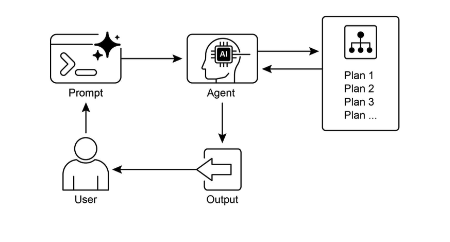
---

## Key Takeaways
- **Planning**은 복잡한 목표를 **실행 가능한 단계(actionable steps)**로 나누는 과정이다.  
- 이런 접근은 **다단계 작업, 워크플로 자동화, 복잡한 문제 해결**에 필수적이다.  
- **LLM**은 주어진 과제를 분석해 **단계별 접근(step-by-step approach)**을 스스로 설계할 수 있다.  
- 프롬프트나 시스템을 설계할 때 **계획을 세우는 과정 자체를 명시적으로 포함**시키면,  
  에이전트의 **계획 능력(planning behavior)**이 더 강화된다.  
- **Google DeepResearch**는 이 패턴의 대표적인 사례로,  
  정보를 **반영(reflect)**하고, **계획(plan)**하고, **실행(execute)**하는 과정을 통해  
  복잡한 주제를 체계적으로 탐구한다.
---

## Conclusion
> **Planning은 에이전트를 단순한 ‘반응형 응답자’에서 ‘전략적 목표 지향 실행자’로 발전시키는 핵심 개념이다.**

- 현대 LLM은 고차원적인 목표를 **일관되고 실행 가능한 단계(coherent, actionable steps)**로 스스로 분해할 수 있다.  
- 이 패턴은 단순한 순차 실행에 머무르지 않고, **Google DeepResearch**처럼  
  지속적으로 정보를 갱신하며 계획을 수정하는 **동적 연구 시스템(dynamic research system)**으로 확장된다.  
- 궁극적으로 Planning은 **인간의 의도(human intent)**와 **자동화된 실행(automated execution)** 사이를 잇는 **핵심 연결 고리**다.  
- 문제 해결 과정을 구조화함으로써, **복잡한 목표를 더 체계적이고 신뢰성 있게 달성**할 수 있도록 만든다.